In [1]:
from tqdm import tqdm
import pandas as pd
import urllib.parse
import urllib.request
import os
import matplotlib.pyplot as plt

In [2]:
def uniprotMapping(query, From="ACC",To="ACC",Format="fasta",Columns=""):
    url = 'https://www.uniprot.org/uploadlists/'
    params={
        "query":query,
        "from":From,
        "to":To,
        "format":Format,
        "columns":Columns,
    }
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = str(f.read(),encoding="utf-8")
    return response

def unirefMapping2pandas(unirefMappingStr,idName):
    mappingDic=dict()
    # First Line is skipped
    for uniref50,clusterSize,ids in [line.split("\t") 
                                     for line 
                                     in unirefMappingStr.split("\n") 
                                     if line.count("\t")>0][1:]:
        for Id in ids.split(","):
            mappingDic[Id]=dict()
            mappingDic[Id][idName+"_uniref50"]=uniref50
            mappingDic[Id][idName+"_uniref50_size"]=int(clusterSize)
    return pd.DataFrame(mappingDic).transpose().reset_index().rename(columns={"index":idName})

def spMappingStr2pandas(spMappingStr):
    mappingDic=dict()
    for sp, Id in [line.split("\t")
                   for line 
                   in spMappingStr.split("\n") 
                   if line.startswith("SIGNAL")]:
        start,end =sp.split(";")[0].split(" ")[-1].split("..")
        mappingDic[Id]=dict()
        mappingDic[Id]["SP_start"]=int(start)
        mappingDic[Id]["SP_end"]=int(end)
    return pd.DataFrame(mappingDic).transpose().reset_index().rename(columns={"index":"Periplasm"})
    
def extractProteinLength(file,newName):
    f = open(file)
    f.readline()
    lengths=dict()
    for line in tqdm(f):
        entry, organism, ec, sequence = line.strip().split("\t")
        lengths[entry]=len(sequence)
    return lengths

def ratioWithoutSP(row):
    CytoLength=row["Cytoplasm_length"]
    PeriLength=row["Periplasm_length"]-row["SP_end"]+row["SP_start"]
    Max = max(CytoLength,PeriLength)
    Min = min(CytoLength,PeriLength)
    return Min/Max

def absDifference(row):
    CytoLength=row["Cytoplasm_length"]
    PeriLength=row["Periplasm_length"]-row["SP_end"]+row["SP_start"]
    Max = max(CytoLength,PeriLength)
    Min = min(CytoLength,PeriLength)
    return Max-Min

In [3]:
# Read all the Twins from Bacteria Dataset
DIR="../2020-04-06.FindTwinsAnyEvidenceBacteria/3.3.twins/"
TWINS_COMBINED=list()                    # Empty list that will be appended in a loop
for FILE in [F for F in os.listdir(DIR) if F.endswith(".tab")]:
    """
    Loop through all the files inside the twins directory.
    Each file corresponds to a bacterial organism and inside is a list of twins.
    """
    ORGANISM=FILE.replace(".tab","")     # Extract organism from file
    FILE_PATH="{}{}".format(DIR,FILE)    # Get full path of FILE
    F = open(FILE_PATH)
    F.readline()                         # First line is header and can be skipped
    for LINE in F:
        CYTOPLASM_PROTEIN, PERIPLASM_PROTEIN = LINE.strip().split("\t")
        TWINS_COMBINED.append((CYTOPLASM_PROTEIN, PERIPLASM_PROTEIN, ORGANISM))
TWINS = pd.DataFrame(TWINS_COMBINED, columns=["Cytoplasm", "Periplasm", "Organism"])
TWINS

,Cytoplasm,Periplasm,Organism
0,A0A5I0AHK7,A0A5I0AM00,Salmonella_enterica_subsp._enterica_serovar_Vi...
1,E6BT71,E6BLU6,Escherichia_coli_MS_85-1
2,A0A5I5GAJ9,A0A5I5G9G4,Salmonella_enterica_subsp._enterica_serovar_Ne...
3,D2AA92,D2ADI4,Shigella_flexneri_serotype_X_strain_2002017
4,A0A5H5RFJ5,A0A5H6V778,Salmonella_enterica_subsp._enterica_serovar_Bu...
...,...,...,...
31160,A0A3T3G9X3,A0A3T3G349,Salmonella_enterica_subsp._enterica_serovar_Br...
31161,A0A080J5A2,A0A080J791,Escherichia_coli_1-250-04_S3_C2
31162,A0A5I1I569,A0A5H7PWL6,Salmonella_enterica_subsp._enterica_serovar_Su...
31163,D8E624,D8E319,Escherichia_coli_MS_119-7


In [4]:
# Get idea of numbers
CYTO_IDS = list(TWINS["Cytoplasm"].unique())
PERI_IDS = list(TWINS["Periplasm"].unique())
ALL_IDS=CYTO_IDS+PERI_IDS
print("Cytoplasmic:", len(CYTO_IDS))
print("Periplasmic:",len(PERI_IDS))
print("All:",len(ALL_IDS))

Cytoplasmic: 1325
Periplasmic: 1902
All: 3227


In [5]:
# Add start and end of Signal peptides
SP_QUERY=" ".join(PERI_IDS)
SP_FROM= "ACC"
SP_TO = "ACC"
SP_FORMAT="tab"
SP_COLUMNS="feature(SIGNAL)"
SP_MAPPING_STR=uniprotMapping(SP_QUERY,
                              From=SP_FROM,
                              To=SP_TO,
                              Format=SP_FORMAT,
                              Columns=SP_COLUMNS)
SP_MAPPING = spMappingStr2pandas(SP_MAPPING_STR)
SP_MAPPING

,Periplasm,SP_start,SP_end
0,A0A5I0AM00,1,34
1,E6BLU6,1,19
2,A0A5I5G9G4,1,34
3,D2ADI4,1,30
4,A0A5H6V778,1,34
...,...,...,...
1764,A0A3T3G349,1,34
1765,A0A080J791,1,30
1766,A0A5H7PWL6,1,34
1767,D8E319,1,19


In [6]:
TWINS=TWINS.merge(SP_MAPPING, on="Periplasm")
TWINS

,Cytoplasm,Periplasm,Organism,SP_start,SP_end
0,A0A5I0AHK7,A0A5I0AM00,Salmonella_enterica_subsp._enterica_serovar_Vi...,1,34
1,E6BT71,E6BLU6,Escherichia_coli_MS_85-1,1,19
2,A0A5I5GAJ9,A0A5I5G9G4,Salmonella_enterica_subsp._enterica_serovar_Ne...,1,34
3,D2AA92,D2ADI4,Shigella_flexneri_serotype_X_strain_2002017,1,30
4,A0A5H5RFJ5,A0A5H6V778,Salmonella_enterica_subsp._enterica_serovar_Bu...,1,34
...,...,...,...,...,...
29001,A0A3T3G9X3,A0A3T3G349,Salmonella_enterica_subsp._enterica_serovar_Br...,1,34
29002,A0A080J5A2,A0A080J791,Escherichia_coli_1-250-04_S3_C2,1,30
29003,A0A5I1I569,A0A5H7PWL6,Salmonella_enterica_subsp._enterica_serovar_Su...,1,34
29004,D8E624,D8E319,Escherichia_coli_MS_119-7,1,19


In [7]:
# Map to Cytoplasmic Ids Uniref50 Groups and get size
CYTO_QUERY=" ".join(CYTO_IDS)
CYTO_FROM= "ACC"
CYTO_TO = "NF50"
CYTO_FORMAT="tab"
CYTO_COLUMNS="id,count"
CYTO_UNIREF50_MAPPING_STR=uniprotMapping(CYTO_QUERY,
                                    From=CYTO_FROM,
                                    To=CYTO_TO,
                                    Format=CYTO_FORMAT,
                                    Columns=CYTO_COLUMNS)
CYTO_UNIREF50_MAPPING = unirefMapping2pandas(CYTO_UNIREF50_MAPPING_STR,"Cytoplasm")
CYTO_UNIREF50_MAPPING

,Cytoplasm,Cytoplasm_uniref50,Cytoplasm_uniref50_size
0,A0A3D4NXJ6,UniRef50_A0A2S7ILA5,7
1,A0A523WVH5,UniRef50_A0A523ZP27,4
2,A0A523ZP27,UniRef50_A0A523ZP27,4
3,A0A497DY78,UniRef50_A0A1M6ELN5,78
4,A0A1F5AA91,UniRef50_A0A0P7AY49,255
...,...,...,...
1256,A0A3T3G9X3,UniRef50_P62602,2175
1257,A0A080J5A2,UniRef50_P62602,2175
1258,A0A5I1I569,UniRef50_P62602,2175
1259,D8E624,UniRef50_P62602,2175


In [8]:
# Map to Periplasmic Ids Uniref50 Groups and get size
PERI_QUERY=" ".join(PERI_IDS)
PERI_FROM= "ACC"
PERI_TO = "NF50"
PERI_FORMAT="tab"
PERI_COLUMNS="id,count"
PERI_UNIREF50_MAPPING_STR=uniprotMapping(PERI_QUERY,
                                    From=PERI_FROM,
                                    To=PERI_TO,
                                    Format=PERI_FORMAT,
                                    Columns=PERI_COLUMNS)
PERI_UNIREF50_MAPPING = unirefMapping2pandas(PERI_UNIREF50_MAPPING_STR,"Periplasm")
PERI_UNIREF50_MAPPING

,Periplasm,Periplasm_uniref50,Periplasm_uniref50_size
0,A0A1Q7ZDV4,UniRef50_A0A1Q7ZDV4,5
1,Q9WXB9,UniRef50_O59651,9906
2,A0A355VWE6,UniRef50_A0A355VWE6,2
3,P44652,UniRef50_P44652,304
4,A0A353XVV4,UniRef50_A0A0B0H6X2,4
...,...,...,...
1769,A0A3T3G349,UniRef50_Q8XDH7,3943
1770,A0A080J791,UniRef50_Q8XDH7,3943
1771,A0A5H7PWL6,UniRef50_Q8XDH7,3943
1772,D8E319,UniRef50_Q8XDH7,3943


In [9]:
TWINS=TWINS\
.merge(CYTO_UNIREF50_MAPPING,on="Cytoplasm")\
.merge(PERI_UNIREF50_MAPPING,on="Periplasm")
TWINS

,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50,Cytoplasm_uniref50_size,Periplasm_uniref50,Periplasm_uniref50_size
0,A0A5I0AHK7,A0A5I0AM00,Salmonella_enterica_subsp._enterica_serovar_Vi...,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
1,E6BT71,E6BLU6,Escherichia_coli_MS_85-1,1,19,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
2,A0A5I5GAJ9,A0A5I5G9G4,Salmonella_enterica_subsp._enterica_serovar_Ne...,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
3,D2AA92,D2ADI4,Shigella_flexneri_serotype_X_strain_2002017,1,30,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
4,A0A5H5RFJ5,A0A5H6V778,Salmonella_enterica_subsp._enterica_serovar_Bu...,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
...,...,...,...,...,...,...,...,...,...
27634,A0A3T3G9X3,A0A3T3G349,Salmonella_enterica_subsp._enterica_serovar_Br...,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
27635,A0A080J5A2,A0A080J791,Escherichia_coli_1-250-04_S3_C2,1,30,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
27636,A0A5I1I569,A0A5H7PWL6,Salmonella_enterica_subsp._enterica_serovar_Su...,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943
27637,D8E624,D8E319,Escherichia_coli_MS_119-7,1,19,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943


In [10]:
CYTO_LENGTHS_FILE="../2020-04-06.FindTwinsAnyEvidenceBacteria/1.downloadProteins/proteinsCytoplasmic.tab"
CYTO_LENGTHS=extractProteinLength(CYTO_LENGTHS_FILE,"Cytoplasm")
TWINS["Cytoplasm_length"]=TWINS["Cytoplasm"].apply(lambda x:CYTO_LENGTHS[x])

7772585it [00:38, 201348.50it/s]


In [11]:
PERI_LENGTHS_FILE="../2020-04-06.FindTwinsAnyEvidenceBacteria/1.downloadProteins/proteinsPeriplasmic.tab"
PERI_LENGTHS = extractProteinLength(PERI_LENGTHS_FILE,"Periplasm")
TWINS["Periplasm_length"]=TWINS["Periplasm"].apply(lambda x:PERI_LENGTHS[x])

171332it [00:00, 182011.44it/s]


In [12]:
TWINS["length_ratio"]=TWINS.apply(ratioWithoutSP,axis=1)
TWINS["length_abs_diff"]=TWINS.apply(absDifference, axis=1)
TWINS=TWINS.sort_values(by="length_abs_diff")

In [13]:
TWINS.to_csv("twins_info.tab",sep="\t")

In [14]:
TWINS

,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50,Cytoplasm_uniref50_size,Periplasm_uniref50,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
1161,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1133,A0A169XQ31,A0A0G3S663,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1147,A0A169XQ31,A0A3E1SVQ6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1154,A0A169XQ31,A0A384I9X6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1126,A0A169XQ31,A0A168N292,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7253,A0A2V9DP80,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A317I3X7,20,UniRef50_A0A3N5ZMI4,1,1161,349,0.285099,830
7259,A0A2V9QGT4,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1177,349,0.281223,846
7229,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848
7228,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848


In [15]:
MAX_LENGTH_RATIO=0.75
TWINS_SIMILAR_LENGTH=TWINS[TWINS["length_ratio"]>MAX_LENGTH_RATIO]
TWINS_SIMILAR_LENGTH

,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50,Cytoplasm_uniref50_size,Periplasm_uniref50,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
1161,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1133,A0A169XQ31,A0A0G3S663,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1147,A0A169XQ31,A0A3E1SVQ6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1154,A0A169XQ31,A0A384I9X6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1126,A0A169XQ31,A0A168N292,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12530,A0A5B7XK32,A0A4V6JJ64,Leclercia_adecarboxylata,1,27,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,662,0.863208,87
12529,A0A514VB47,A0A4V6JJ64,Leclercia_adecarboxylata,1,27,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,662,0.863208,87
15618,Q7M8K1,Q7M827,Wolinella_succinogenes_strain_ATCC_29543__DSM_...,1,33,UniRef50_A0A432R1Z2,206,UniRef50_Q7M827,379,479,613,0.824441,102
12577,P28904,P25718,Escherichia_coli_strain_K12,1,17,UniRef50_P28904,4199,UniRef50_P25718,5447,551,676,0.834848,109


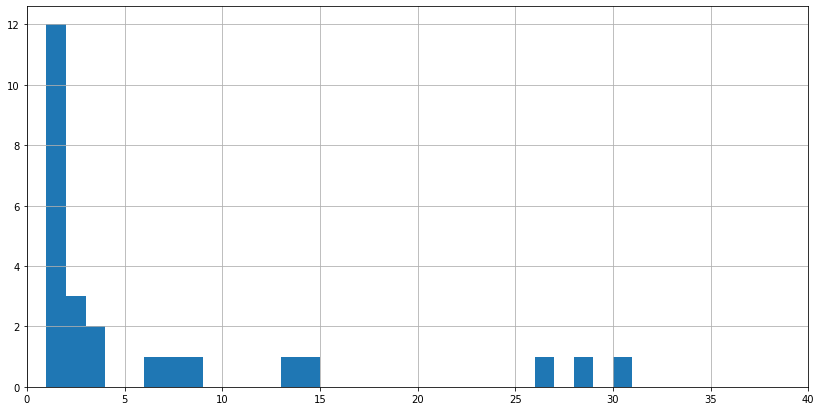

In [16]:
TWINS_BY_UNIREF50_SIZE = TWINS_SIMILAR_LENGTH.groupby(["Cytoplasm_uniref50","Periplasm_uniref50"]).size().sort_values()
plt.figure(figsize=(14,7))
TWINS_BY_UNIREF50_SIZE.hist(bins=range(0,40))
plt.xlim((0,40))
plt.show()

In [17]:
TWINS_BY_UNIREF50_SIZE[TWINS_BY_UNIREF50_SIZE>25]

Cytoplasm_uniref50   Periplasm_uniref50 
UniRef50_A0A0U3K4G8  UniRef50_Q8XDH7           26
UniRef50_Q8ZRT8      UniRef50_Q32JZ5           28
UniRef50_A0A0U3K4G8  UniRef50_A0A4U2UH78       30
UniRef50_P62602      UniRef50_Q8XDH7        19555
dtype: int64

The last Uniref group have a lot of members!

* UniRef50_P62602 : UniRef - Cluster: Cytoplasmic trehalase (50%)
* UniRef50_Q8XDH7: UniRef - Cluster: Putative periplasmic trehalase (50%)

They occur in a lot of different species.
Though it should be noted that classification in this table is done until strain level.
Because a lot of the species in this group are interesting for us (E.coli, Salmonella, ...), there are naturally many organisms.
But anyhow, there is already a lot studies about this protein.

In [18]:
len(TWINS[TWINS["Cytoplasm_uniref50"]=="UniRef50_P62602"]["Organism"].unique())

588

In [19]:
TWINS_BY_UNIREF50 = TWINS_SIMILAR_LENGTH\
.groupby(["Cytoplasm_uniref50","Periplasm_uniref50"],as_index=False)\
.first()\
.sort_values(by="length_abs_diff")\
.reset_index(drop=True)
TWINS_BY_UNIREF50

,Cytoplasm_uniref50,Periplasm_uniref50,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50_size,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,UniRef50_P62602,UniRef50_Q8XDH7,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,2175,3943,549,582,1.000000,0
1,UniRef50_D4I261,UniRef50_Q8XDH7,V5ZBR4,V5Z7Z1,Erwinia_piriflorinigrans_CFBP_5888,1,24,81,3943,536,558,0.998134,1
2,UniRef50_Q96VT4,UniRef50_O59651,Q9ZGM4,Q9WXB9,Legionella_pneumophila,1,27,1678,9906,721,749,0.997234,2
3,UniRef50_P83221,UniRef50_O53021,P23869,P0AFL3,Escherichia_coli_strain_K12,1,24,4189,2118,164,190,0.982036,3
4,UniRef50_P62602,UniRef50_A0A090V295,A0A2S4QQI7,A0A2S4QRB0,Escherichia_sp._ESNIH1,1,34,2175,17,549,579,0.994536,3
5,UniRef50_P12994,UniRef50_P77368,P12994,P77368,Escherichia_coli_strain_K12,1,21,1160,1614,158,183,0.969325,5
6,UniRef50_D4I261,UniRef50_A0A4U2UH78,A0A2S9IE12,A0A2S9ICJ4,Pantoea_coffeiphila,1,31,81,79,535,558,0.986916,7
7,UniRef50_A0A0U3K4G8,UniRef50_Q8XDH7,E1SDR6,E1SAD0,Pantoea_vagans_strain_C9-1_Pantoea_agglomerans...,1,33,112,3943,519,561,0.981096,10
8,UniRef50_P62602,UniRef50_Q9I165,A0A2U1U468,A0A2U1TM39,Brenneria_sp._CFCC_11842,1,30,2175,1311,551,570,0.981851,10
9,UniRef50_P0A963,UniRef50_P00805,P0A962,P00805,Escherichia_coli_strain_K12,1,22,3836,2537,338,348,0.967456,11


In [20]:
MIN_CLUSTER_SIZE=100
TWINS_BY_UNIREF50_ENOUGH_DATA=TWINS_BY_UNIREF50[
    (TWINS_BY_UNIREF50["Cytoplasm_uniref50_size"]>MIN_CLUSTER_SIZE)\
    &(TWINS_BY_UNIREF50["Periplasm_uniref50_size"]>MIN_CLUSTER_SIZE)\
]\
.sort_values(by="length_abs_diff")\
.reset_index(drop=True)
TWINS_BY_UNIREF50_ENOUGH_DATA

,Cytoplasm_uniref50,Periplasm_uniref50,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50_size,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,UniRef50_P62602,UniRef50_Q8XDH7,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,2175,3943,549,582,1.000000,0
1,UniRef50_Q96VT4,UniRef50_O59651,Q9ZGM4,Q9WXB9,Legionella_pneumophila,1,27,1678,9906,721,749,0.997234,2
2,UniRef50_P83221,UniRef50_O53021,P23869,P0AFL3,Escherichia_coli_strain_K12,1,24,4189,2118,164,190,0.982036,3
3,UniRef50_P12994,UniRef50_P77368,P12994,P77368,Escherichia_coli_strain_K12,1,21,1160,1614,158,183,0.969325,5
4,UniRef50_A0A0U3K4G8,UniRef50_Q8XDH7,E1SDR6,E1SAD0,Pantoea_vagans_strain_C9-1_Pantoea_agglomerans...,1,33,112,3943,519,561,0.981096,10
5,UniRef50_P62602,UniRef50_Q9I165,A0A2U1U468,A0A2U1TM39,Brenneria_sp._CFCC_11842,1,30,2175,1311,551,570,0.981851,10
6,UniRef50_P0A963,UniRef50_P00805,P0A962,P00805,Escherichia_coli_strain_K12,1,22,3836,2537,338,348,0.967456,11
7,UniRef50_Q32JZ5,UniRef50_Q32JZ5,A0A1C3H8R2,A0A2V4G4C5,Serratia_marcescens,1,37,878,878,153,176,0.915033,13
8,UniRef50_A0A0U3K4G8,UniRef50_Q9I165,A0A1V9DGI1,A0A1V9DC43,Pantoea_latae,1,33,112,1311,552,561,0.958333,23
9,UniRef50_P0AAL2,UniRef50_P0AAL4,A0A3R0NUQ6,P0AAL5,Shigella_flexneri,1,41,1270,492,164,231,0.858639,27


In [21]:
TWINS_BY_UNIREF_VERY_STRICT=TWINS_BY_UNIREF50_ENOUGH_DATA\
.groupby("Periplasm_uniref50",as_index=False).first().sort_values(by="length_abs_diff")\
.groupby("Cytoplasm_uniref50",as_index=False).first().sort_values(by="length_abs_diff")\
.reset_index(drop=True)
TWINS_BY_UNIREF_VERY_STRICT

,Cytoplasm_uniref50,Periplasm_uniref50,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50_size,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,UniRef50_P62602,UniRef50_Q8XDH7,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,2175,3943,549,582,1.000000,0
1,UniRef50_Q96VT4,UniRef50_O59651,Q9ZGM4,Q9WXB9,Legionella_pneumophila,1,27,1678,9906,721,749,0.997234,2
2,UniRef50_P83221,UniRef50_O53021,P23869,P0AFL3,Escherichia_coli_strain_K12,1,24,4189,2118,164,190,0.982036,3
3,UniRef50_P12994,UniRef50_P77368,P12994,P77368,Escherichia_coli_strain_K12,1,21,1160,1614,158,183,0.969325,5
4,UniRef50_P0A963,UniRef50_P00805,P0A962,P00805,Escherichia_coli_strain_K12,1,22,3836,2537,338,348,0.967456,11
5,UniRef50_Q32JZ5,UniRef50_Q32JZ5,A0A1C3H8R2,A0A2V4G4C5,Serratia_marcescens,1,37,878,878,153,176,0.915033,13
6,UniRef50_P0AAL2,UniRef50_P0AAL4,A0A3R0NUQ6,P0AAL5,Shigella_flexneri,1,41,1270,492,164,231,0.858639,27
7,UniRef50_Q2NVU4,UniRef50_Q2NVU4,A0A193QGU2,Q2NVU4,Sodalis_glossinidius_strain_morsitans,1,29,124,124,167,167,0.832335,28
8,UniRef50_Q8ZRT8,UniRef50_Q8ZRT8,A0A4V0HDT9,A0A4Q8ES36,Escherichia_coli,1,37,1014,1014,165,170,0.812121,31
9,UniRef50_P10902,UniRef50_P0C278,Q07YY9,Q07WU7,Shewanella_frigidimarina_strain_NCIMB_400,1,25,6730,160,538,596,0.940559,34


In [22]:
TWINS_BY_UNIREF_VERY_STRICT.to_csv("twins_very_strict.tab",sep="\t", index=False)